In [1]:
import os
import sys

sys.path.append(os.path.abspath("../src"))

In [124]:
# Import packages
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import muspan as ms
import numpy as np
import scanpy as sc
import spatialdata as sd
import squidpy as sq
import seaborn as sns

In [7]:
# Set variables
module_name = "5_muspan"  # name of the module


In [14]:
# Set directories
base_dir = "/Users/sarapatti/Desktop/PhD_projects/Llyod_lab/ReCoDe-spatial-transcriptomics"
input_path = base_dir
output_path = Path(base_dir) / "analysis"
logging_path = Path(output_path) / "logging"
zarr_path = Path(input_path) / "data/xenium.zarr"
area_path = Path(input_path) / "data/section_one_cells.csv"

# Confirm directories exist
if not Path(input_path).exists():
    raise FileNotFoundError(f"Input path {input_path} does not exist.")
if not Path(output_path).exists():
    raise FileNotFoundError(f"Output path {output_path} does not exist.")
if not Path(zarr_path).exists():
    raise FileNotFoundError(f"Logging path {zarr_path} does not exist.")

In [10]:
# Create output directories if they do not exist
os.makedirs(Path(output_path) / module_name, exist_ok=True)

# Set up logging
os.makedirs(
    logging_path, exist_ok=True
)  # should set up all these directories at the start of the pipeline?
logging.basicConfig(
    filename=Path(logging_path) / f"{module_name}.txt",  # output file
    filemode="w",  # overwrites the file each time
    format="%(asctime)s - %(levelname)s - %(message)s",  # log format
    level=logging.INFO,  # minimum level to log
)



# change directory to output_path/module_name
os.chdir(
    Path(output_path) / module_name
)  # need to so plots save in the correct directory

In [125]:
# Set colors
color_map = sns.color_palette("crest", as_cmap=True)

In [13]:
# Import data
logging.info("Loading Xenium data...")
adata = sc.read_h5ad(Path(output_path) / "4_view_images/adata.h5ad")
sdata = sd.read_zarr(zarr_path)

In [22]:
# Import Xenium data using muspan
transcripts_of_interest = ["EPCAM", "CD3D", "CD68", "VWF", "PTPRC", "ACTA2"]

pc = ms.io.xenium_to_domain(
    path_to_xenium_data="/Users/sarapatti/Desktop/PhD_projects/Llyod_lab/ReCoDe-spatial-transcriptomics/data/xenium",
    cells_from_selection_csv = area_path,
    domain_name='A test domain',
    load_transcripts=True,
    selected_transcripts=transcripts_of_interest,
    load_nuclei=True,
    load_cells_as_shapes=True,
    exclude_no_nuclei_cells=True)

Domain name: A test domain
Number of objects: 7954
Collections: ['Cell boundaries', 'Nucleus boundaries', 'Transcripts']
Labels: ['Cell ID', 'Transcript Counts', 'Cell Area', 'Cluster ID', 'Nucleus Area', 'Transcript ID'] 
Networks: [] 
Distance matrices: []


In [23]:
print(pc)

Domain name: A test domain
Number of objects: 7954
Collections: ['Cell boundaries', 'Nucleus boundaries', 'Transcripts']
Labels: ['Cell ID', 'Transcript Counts', 'Cell Area', 'Cluster ID', 'Nucleus Area', 'Transcript ID'] 
Networks: [] 
Distance matrices: []


In [39]:
pc.collections['Transcripts']

{'collection_name': 'Transcripts',
 'collection_name_integer': 2,
 'objects': array([2866., 2867., 2868., ..., 7951., 7952., 7953.])}

In [27]:
# Queries to isolate the different objects within the MuSpAn domain

# Query to isolate cell boundaries
qCells = ms.query.query(pc, ('Collection',), 'is', 'Cell boundaries')

# Query to isolate transcripts
qTrans = ms.query.query(pc, ('Collection',), 'is', 'Transcripts')

# Query to isolate nucleus boundaries
qNuc = ms.query.query(pc, ('Collection',), 'is', 'Nucleus boundaries')

In [ ]:
print(pc.labels.keys())  # see all keys in the labels dictionary

dict_keys(['Cell ID', 'Transcript Counts', 'Cell Area', 'Cluster ID', 'Nucleus Area', 'Transcript ID'])


Text(0.5, 1.0, 'Nuclei')

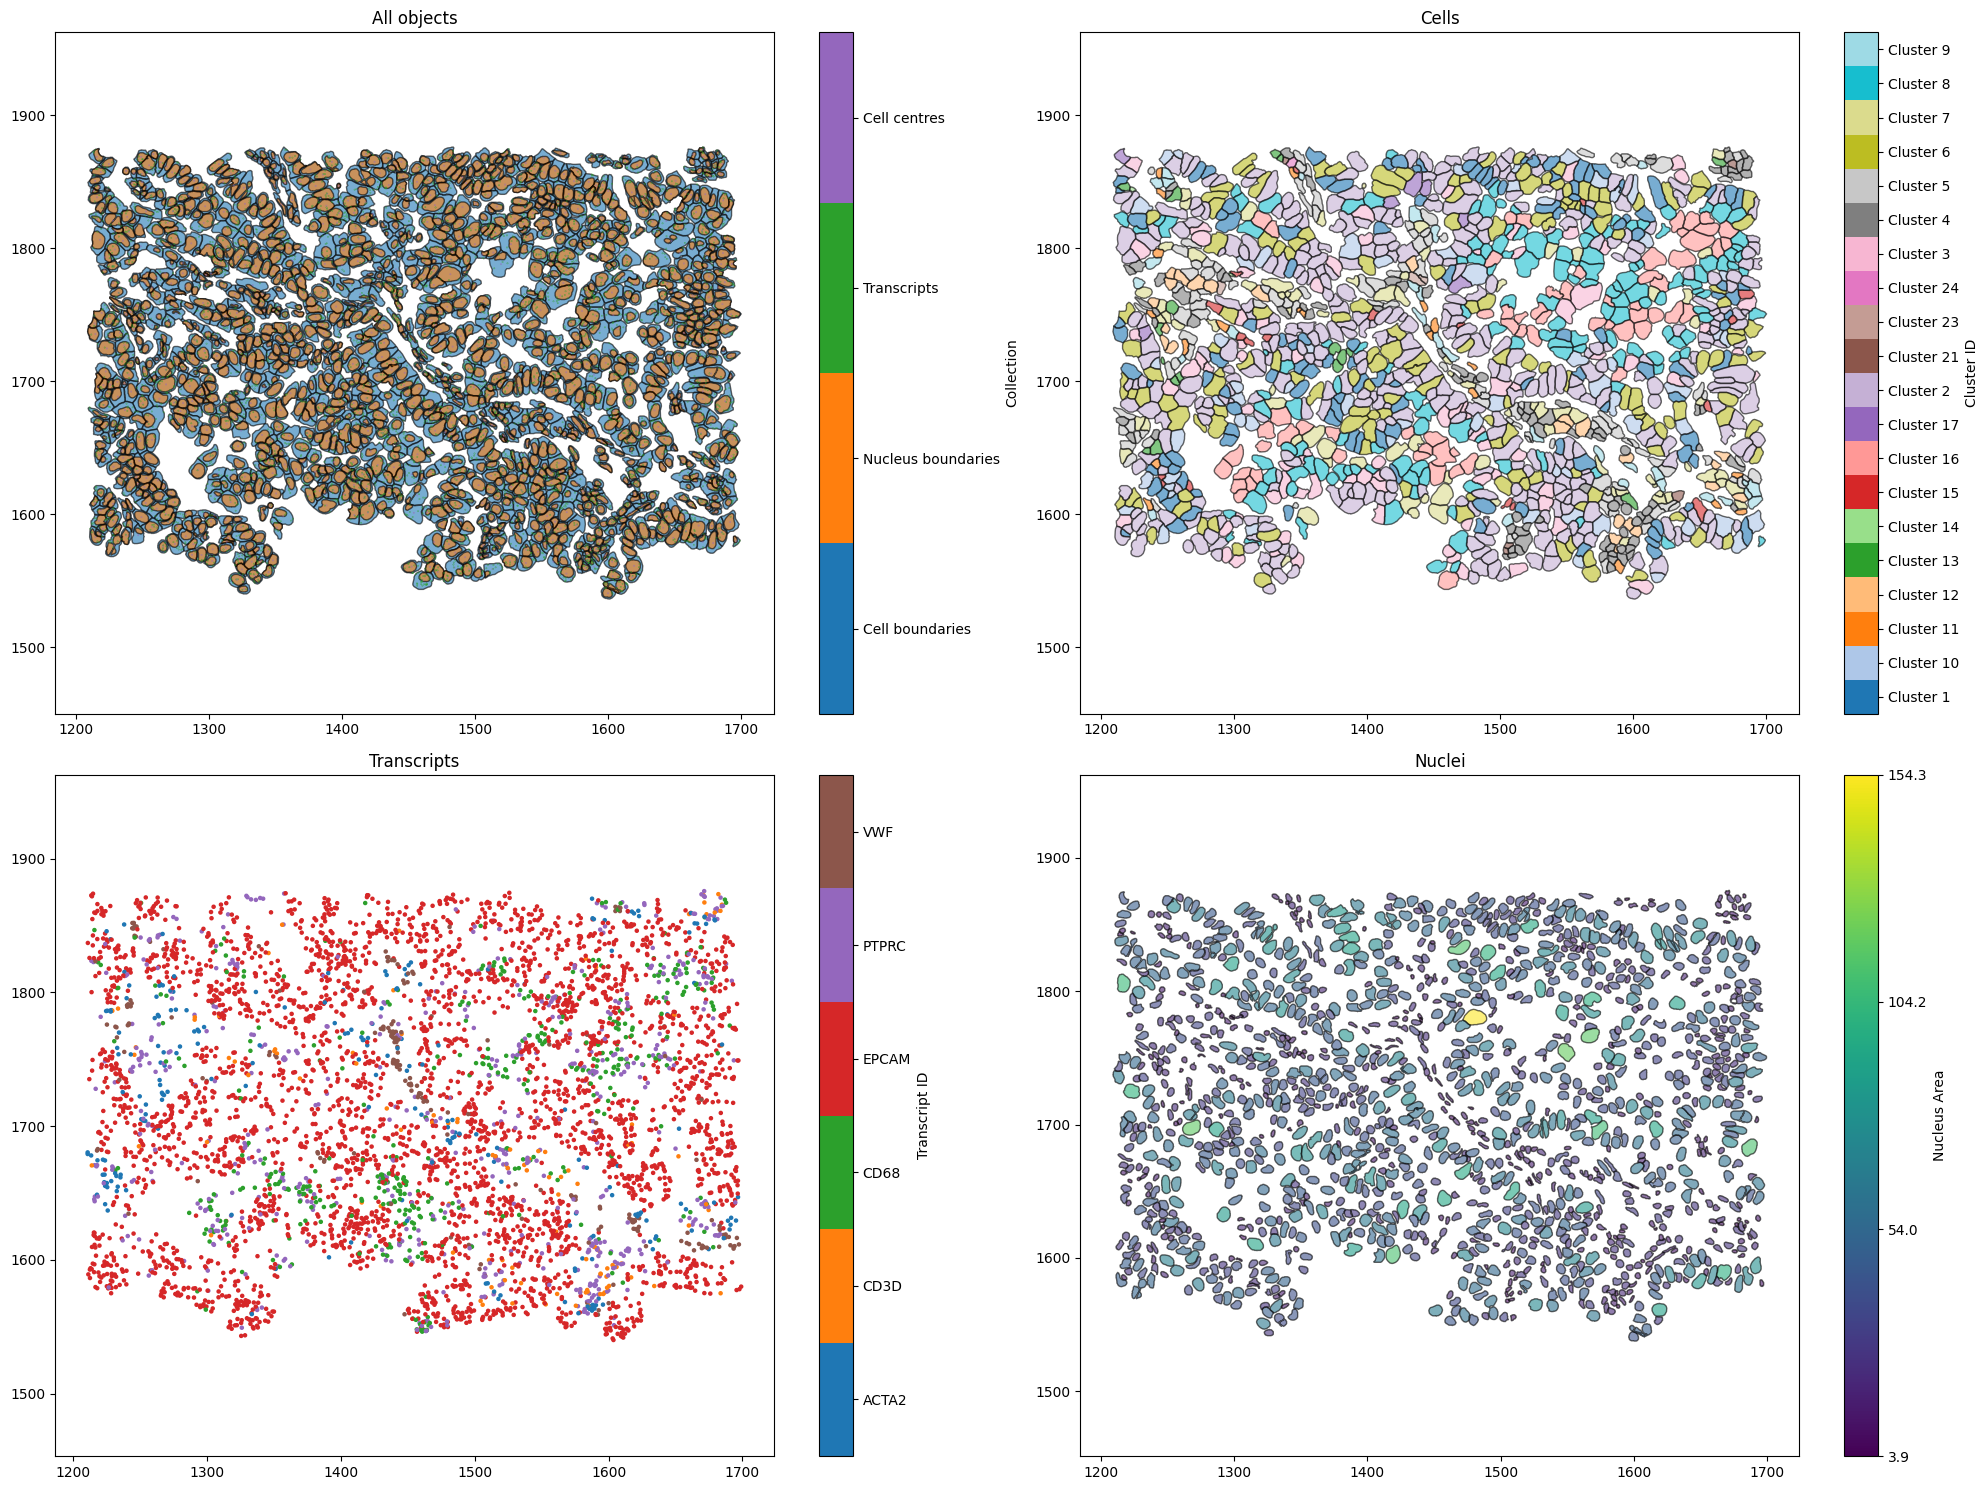

In [128]:
# Create a figure with 2x2 subplots
fig, ax = plt.subplots(figsize=(20, 15), nrows=2, ncols=2)

# Visualise all objects in the MuSpAn domain
ms.visualise.visualise(pc, ax=ax[0, 0], 
                       marker_size=0.05)
ax[0, 0].set_title('All objects')

# Visualise cells, colored by 'Cluster ID'
ms.visualise.visualise(pc, 
                       color_by=('label', 'Cluster ID'), 
                       ax=ax[0, 1], 
                       objects_to_plot=qCells)
ax[0, 1].set_title('Cells')

# Visualise transcripts, colored by 'Transcript'
ms.visualise.visualise(pc, 
                       color_by=('label', 'Transcript ID'), 
                       ax=ax[1, 0], 
                       objects_to_plot=qTrans, 
                       marker_size=5)
ax[1, 0].set_title('Transcripts')

# Visualise nuclei, colored by 'Nucleus Area'
ms.visualise.visualise(pc, color_by=('label', 'Nucleus Area'),
                       ax=ax[1, 1], 
                       objects_to_plot=qNuc, 
                       #vmin=20, 
                       #vmax=200
                       )
ax[1, 1].set_title('Nuclei')

# Creating spatial networks

## Delaunay networks from point-like data

If no boundary information about our spatial objects is given in our dataset (i.e., no segmentation mask), then Deluanay networks on point-like data are a common approximation of the local connectivity of the data. It’s construction is based on area (volume) filling process between all points such that edges are generated to produce triangles that do not contain any other point, therefore an edge between points presents the adjacency of the voronoi cells of the data.

Edge weights are values that can be used to describe the connectivity between nodes.

(<Figure size 1000x600 with 2 Axes>, <Axes: >)

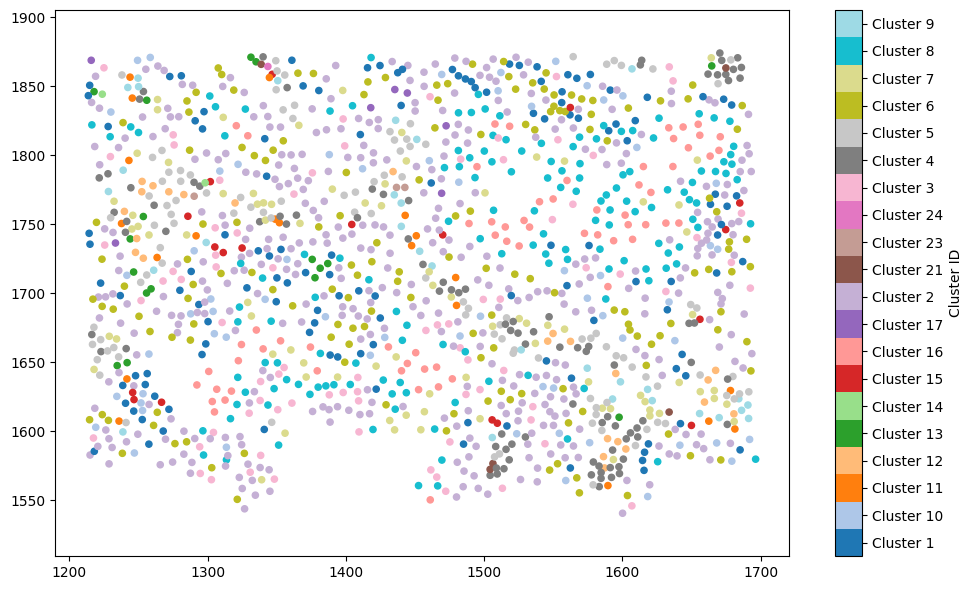

In [139]:
# Convert cell boundaries to cell centres (centroids)
pc.convert_objects(
    population=('Collection', 'Cell boundaries'),
    object_type='point',
    conversion_method='centroids',
    collection_name='Cell centroids',
    inherit_collections=False
)

# Plot the cell centres with color based on 'Cluster ID'
plt.figure(figsize=(10, 6))
ms.visualise.visualise(
    pc,
    objects_to_plot=('collection', 'Cell centroids'),
    color_by='Cluster ID',
    ax=plt.gca()
)

In [140]:
# Generate a Delaunay network on the 'Cell centroids' data
# The network will be stored in the domain.networks dictionary with the name 'Delaunay CC'
del_network = ms.networks.generate_network(pc,
                             network_name='Delaunay CC filtered',
                             network_type='Delaunay',
                             objects_as_nodes=('collection','Cell centroids'),
                             min_edge_distance=0,
                             max_edge_distance=20
                             )

In [141]:
del_network = ms.networks.generate_network(pc,
                             network_name='Delaunay CC unfiltered',
                             network_type='Delaunay',
                             objects_as_nodes=('collection','Cell centroids')
                             )

In [56]:
list(del_network.edges(data=True))[0]

(7955, 7975, {'Distance': 6.057404240397282, 'Inverse Distance': 1.0})

In [60]:
print('Delaunay CC unfiltered:',pc.networks['Delaunay CC unfiltered'])
print('Delaunay CC filtered:',pc.networks['Delaunay CC filtered'])

Delaunay CC unfiltered: Graph with 1433 nodes and 4282 edges
Delaunay CC filtered: Graph with 1433 nodes and 3494 edges


(<Figure size 1300x600 with 2 Axes>,
 <Axes: title={'center': 'Delaunay CC filtered'}>)

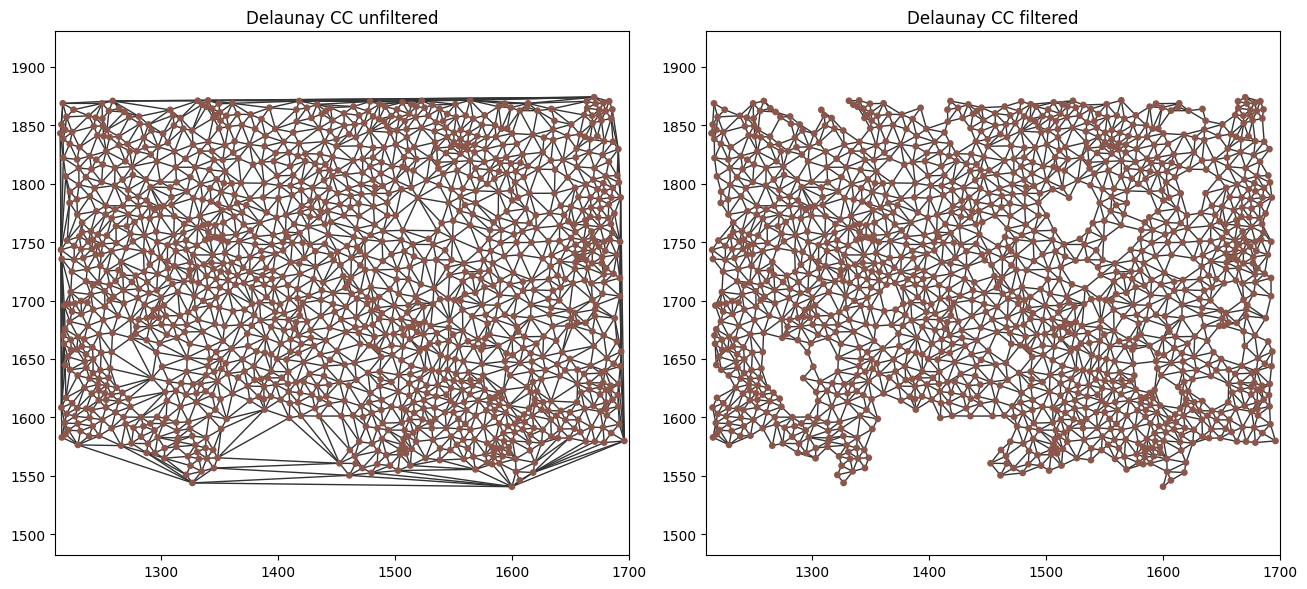

In [142]:
# Create a 1x2 subplot for visualizing the original and filtered Delaunay networks
fig, ax = plt.subplots(1, 2, figsize=(13, 6))

# Plot the original Delaunay network
ax[0].set_title('Delaunay CC unfiltered')
ms.visualise.visualise_network(
    pc,
    network_name='Delaunay CC unfiltered',
    ax=ax[0],
    edge_weight_name=None,
    visualise_kwargs=dict(objects_to_plot=('collection', 'Cell centroids'), marker_size=15, add_cbar=False)
)

# Plot the filtered Delaunay network
ax[1].set_title('Delaunay CC filtered')
ms.visualise.visualise_network(
    pc,
    network_name='Delaunay CC filtered',
    ax=ax[1],
    edge_weight_name=None,
    visualise_kwargs=dict(objects_to_plot=('collection', 'Cell centroids'), marker_size=15, add_cbar=False)
)

# Proximity based networks

Proximity networks are purely distance-based networks. Formally, in a Proximity network, any two nodes are connected if the distance between is within a specified range, which is defined in our case by max_edge_distance and min_edge_distance. These networks are particularly useful in spatial analysis where the physical distance between objects is a key factor. By adjusting the distance thresholds, we can explore how connectivity changes at different spatial scales. This can help in understanding the spatial organization and interactions within the dataset.

### Point-like objects

In [143]:
# Generate proximity networks with different maximum edge distances

# Proximity network with 10μm max distance
ms.networks.generate_network(
    pc,
    network_name='prox network centroids 10',
    network_type='Proximity',
    objects_as_nodes=('collection', 'Cell centroids'),
    max_edge_distance=10,
    min_edge_distance=0
)

# Proximity network with 30μm max distance
ms.networks.generate_network(
    pc,
    network_name='prox network centroids 30',
    network_type='Proximity',
    objects_as_nodes=('collection', 'Cell centroids'),
    max_edge_distance=30,
    min_edge_distance=0
)

# Proximity network with 50μm max distance
ms.networks.generate_network(
    pc,
    network_name='prox network centroids 50',
    network_type='Proximity',
    objects_as_nodes=('collection', 'Cell centroids'),
    max_edge_distance=50,
    min_edge_distance=0
)

(<Figure size 2500x600 with 7 Axes>,
 <Axes: title={'center': 'Proximity network: 50μm max distance'}>)

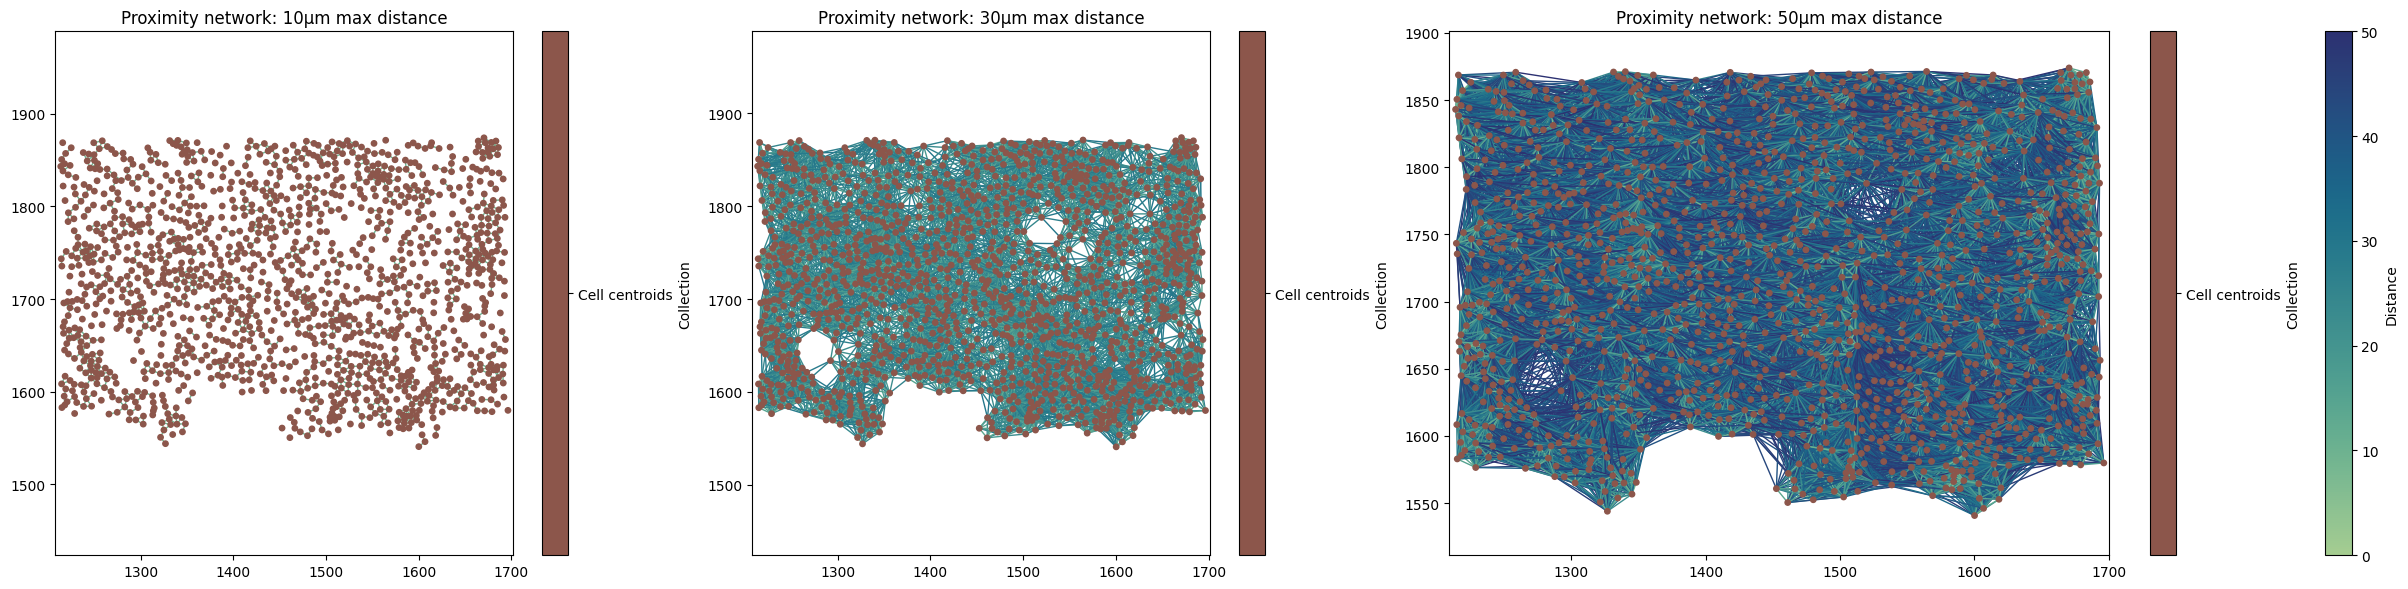

In [144]:
# Create a figure with 3 subplots arranged in a single row
fig, ax = plt.subplots(1, 3, figsize=(25, 6), gridspec_kw={'width_ratios': [1, 1, 1.8]})

# Plot the proximity network with 10μm max distance
ax[0].set_title('Proximity network: 10μm max distance')
ms.visualise.visualise_network(
    pc,
    network_name='prox network centroids 10',
    ax=ax[0],
    edge_cmap=color_map,
    edge_vmin=0,
    edge_vmax=50,
    add_cbar=False,
    visualise_kwargs=dict(objects_to_plot=('collection', 'Cell centroids'), marker_size=15)
)

# Plot the proximity network with 30μm max distance
ax[1].set_title('Proximity network: 30μm max distance')
ms.visualise.visualise_network(
    pc,
    network_name='prox network centroids 30',
    ax=ax[1],
    edge_cmap=color_map,
    edge_vmin=0,
    edge_vmax=50,
    add_cbar=False,
    visualise_kwargs=dict(objects_to_plot=('collection', 'Cell centroids'), marker_size=15)
)

# Plot the proximity network with 50μm max distance
ax[2].set_title('Proximity network: 50μm max distance')
ms.visualise.visualise_network(
    pc,
    network_name='prox network centroids 50',
    ax=ax[2],
    edge_cmap=color_map,
    edge_vmin=0,
    edge_vmax=50,
    visualise_kwargs=dict(objects_to_plot=('collection', 'Cell centroids'), marker_size=15)
)

### Shape-like objects

Note that the ‘Contact network’ is defined between the ‘Cell boundary’ objects but edges will be drawn from their centroids. For purely visualisation purposes, we include the ‘Cell centroids’ on the plot.

In [113]:
# Generate a proximity network from shape-like objects (Cell boundaries)
# with a maximum edge distance of 1.5μm

ms.networks.generate_network(
    pc,
    network_name='Contact network',
    network_type='Proximity',
    objects_as_nodes=('collection', 'Cell boundaries'),
    max_edge_distance=10,
    min_edge_distance=0
)

(<Figure size 1200x1000 with 2 Axes>, <Axes: >)

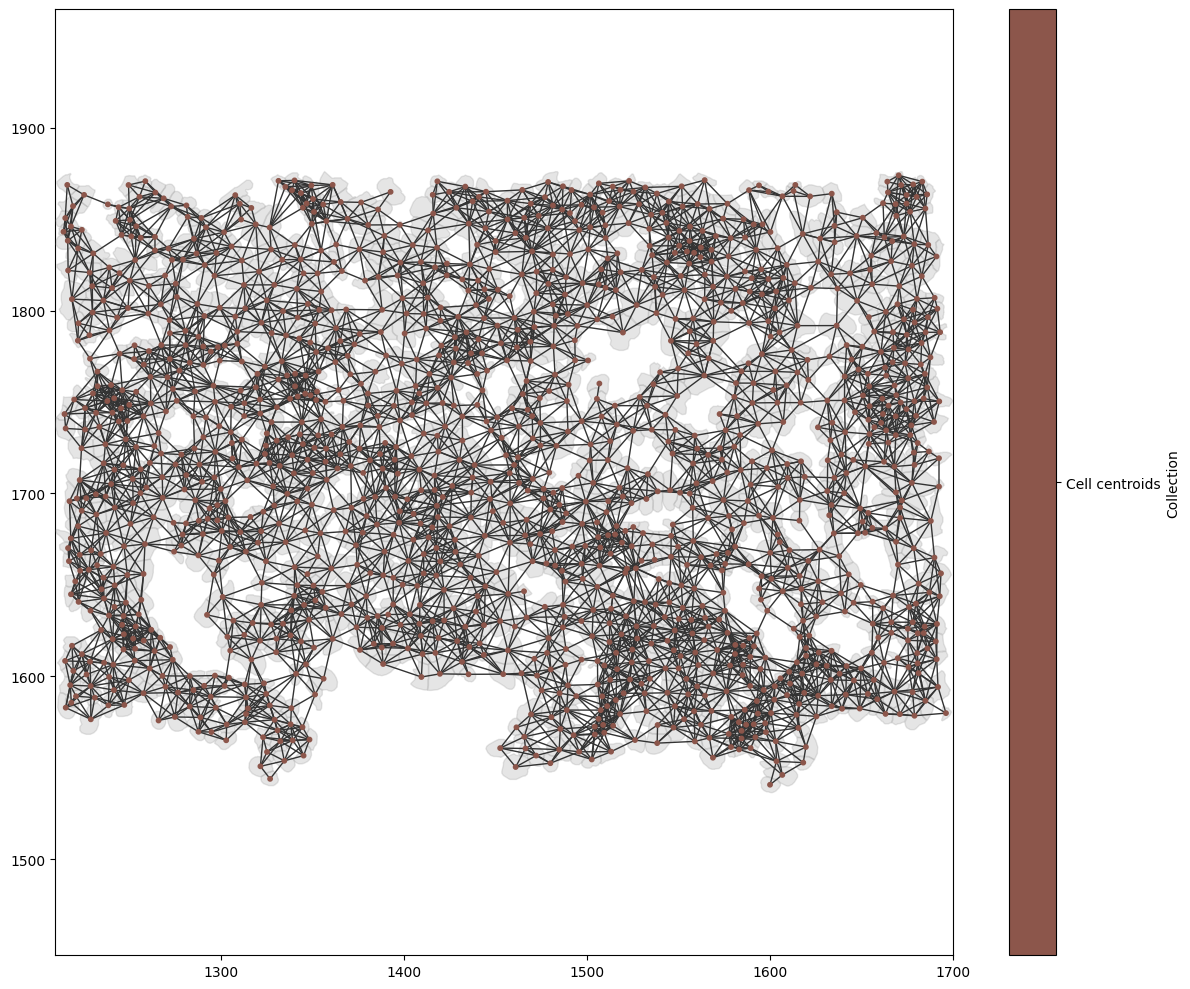

In [145]:
# Create a figure with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the cell boundaries underneath the network
ms.visualise.visualise(
    pc,
    ax=ax,
    objects_to_plot=('collection', 'Cell boundaries'),
    marker_size=15,
    add_cbar=False,
    shape_kwargs={'color': 'grey', 'alpha': 0.2, 'edgecolor': 'black'},
)

# Plot the contact network on top of the cell boundaries
ms.visualise.visualise_network(
    pc,
    network_name='Contact network',
    ax=ax,
    edge_weight_name=None,
    visualise_kwargs=dict(objects_to_plot=('collection', 'Cell centroids'), 
                          marker_size=10,
                        ),
)

# KNN based networks

Network_method argument and defining the number of neighbours we’d like to connect for every node using the number_of_nearest_neighbours parameter

In [156]:
# Generate a K-Nearest Neighbours (KNN) network on the 'Cell centroids' data with k neighbors
k = 10

ms.networks.generate_network(
    pc,
    network_name=f"{k}-NN network",
    network_type='KNN',
    objects_as_nodes=('collection', 'Cell centroids'),
    number_of_nearest_neighbours=k
)

(<Figure size 1000x600 with 3 Axes>, <Axes: >)

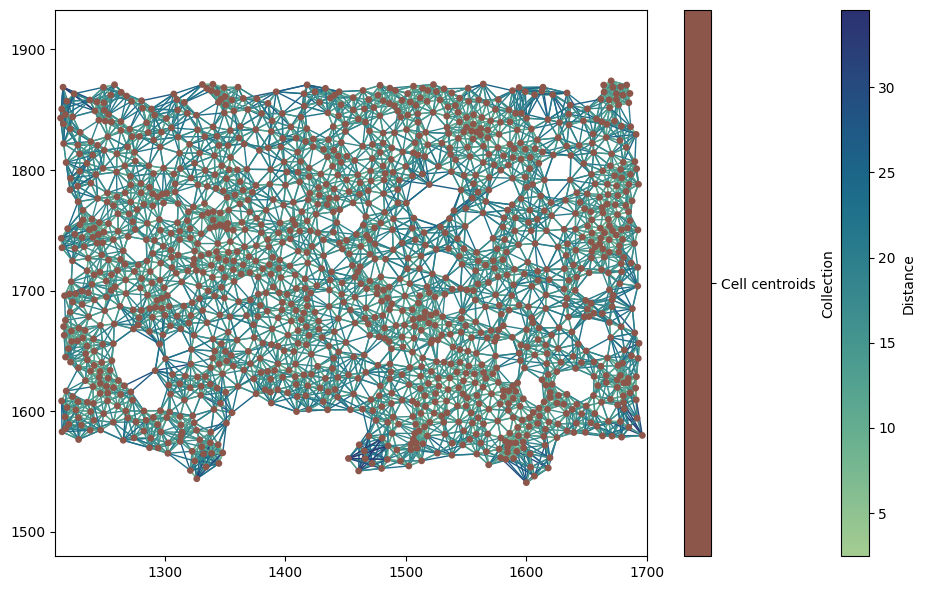

In [157]:
# Create a figure and axis for plotting the KNN network
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Visualise the 10-NN network on the 'Cell centroids' data
ms.visualise.visualise_network(
    pc,
    network_name=f"{k}-NN network",
    ax=ax,
    edge_weight_name='Distance',
    edge_cmap=color_map,
    visualise_kwargs=dict(
        objects_to_plot=('collection', 'Cell centroids'),
        marker_size=15
    )
)

We can see that each object should be connected to only 10 other objects in our domain

In [159]:
# Initialize an empty list to store the number of neighbours for each node
number_of_neighbours_check = []

# Iterate through each node in the 'f"{k}-NN network"k'
for node in pc.networks[f"{k}-NN network"].nodes():
    # Append the number of neighbours for the current node to the list
    number_of_neighbours_check.append(len(list(pc.networks[f"{k}-NN network"].neighbors(node))))

# Print the number of adjacent nodes for the first 100 nodes
print('Number of adjacent nodes for the first 100 nodes:', number_of_neighbours_check[:100])

Number of adjacent nodes for the first 100 nodes: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


# Spatial analysis

### Cross pair correlation function (cross-PCF)

The cross pair correlation function (cross-PCF, also known as the Radial Distribution Function) is a spatial statistic that characterises clustering or exclusion at different length scales. Consider two populations of points, that we’ll call 
 and 
. Then the cross-PCF, 
, can be thought of as a ratio describing whether the observed number of pairs of points separated by distance 
 (where one is type 
 and the other type 
) is higher or lower than would be expected under a statistical null model. In brief, 
 indicates increased numbers of 
 pairs separated by distance 
, which indicates clustering. 
 suggests exclusion, or regularity.

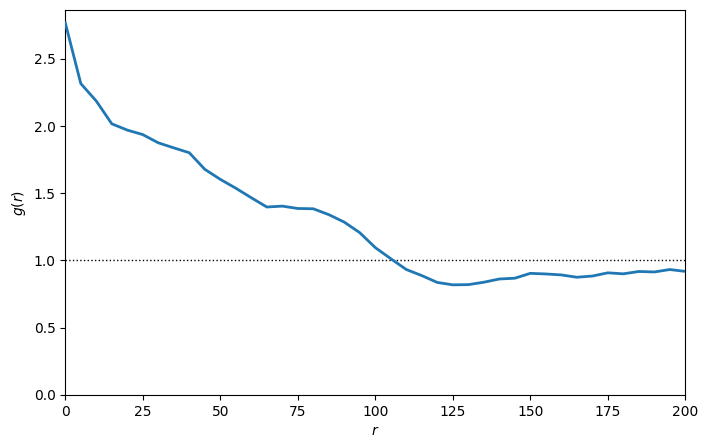

In [162]:
# Query the domain for points of Celltype D
pop_8 = ms.query.query(pc, ('label', 'Cluster ID'), 'is', 'Cluster 8')

# Calculate the cross-PCF for points of Celltype D with themselves
# max_R: maximum radius to consider
# annulus_step: step size for the annulus
# annulus_width: width of the annulus
# visualise_output: whether to visualise the output
r, PCF = ms.spatial_statistics.cross_pair_correlation_function(
    domain=pc,
    population_A=pop_8,
    population_B=pop_8,
    max_R=200,
    annulus_step=5,
    annulus_width=25,
    visualise_output=True
)

In [194]:
celltypes = pc.labels['Cluster ID']['labels'].tolist()
celltypes = np.unique(celltypes)
len(celltypes)

20

In [ ]:
# Define the cell types to be analyzed
celltypes = pc.labels['Cluster ID']['labels'].tolist()
celltypes = np.unique(celltypes)

# Create a 4x4 subplot for visualizing the cross-PCF for each combination of cell types
fig, axes = plt.subplots(20, 20, figsize=(12, 12))

# Loop through each combination of cell types
for i in range(len(celltypes)):
    for j in range(len(celltypes)):
        pop_A = ms.query.query(pc, ('label', 'Cluster ID'), 'is', celltypes[i])
        pop_B = ms.query.query(pc, ('label', 'Cluster ID'), 'is', celltypes[j])
        r, PCF = ms.spatial_statistics.cross_pair_correlation_function(
            pc,
            pop_A,
            pop_B,
            max_R=200,
            annulus_step=5,
            annulus_width=25
        )

        # Select the current subplot
        ax = axes[i, j]

        # Plot the cross-PCF
        ax.plot(r, PCF)

        # Add a horizontal line at y=1 to indicate the CSR baseline
        ax.axhline(1, color='k', linestyle=':')

        # Set the y-axis limit
        ax.set_ylim([0, 7])

        # Label the y-axis with the cross-PCF notation
        ax.set_ylabel(f'$g_{{{celltypes[i]}{celltypes[j]}}}(r)$')

        # Label the x-axis with the distance r
        ax.set_xlabel('$r$')

# Adjust the layout to prevent overlap
plt.tight_layout()

### The weighted pair correlation function (wPCF)
The weighted pair correlation function (wPCF) is a spatial statistic that extends the standard pair correlation function to identify spatial relationships between two point populations, one of which is labelled with a continuous mark. For full details, see https://doi.org/10.1371/journal.pcbi.1010994 or https://doi.org/10.1017/S2633903X24000011.

In this tutorial, we briefly reproduce the example from Figure 3 of Quantification of spatial and phenotypic heterogeneity in an agent-based model of tumour-macrophage interactions (PLOS Computational Biology 19(3) https://doi.org/10.1371/journal.pcbi.1010994). We start by placing a line of points from population 
 across the line 
, and a second population 
 placed randomly across the domain. Population 
 points are assigned a mark 


In [ ]:
# Query population A from the domain
popA = ms.query.query(pc, ('label', 'Cluster ID'), 'is', 'Cluster 8')

# Query population B from the domain
popB = ms.query.query(pc, ('label', 'Cluster ID'), 'is', 'Cluster 2')

# Calculate the weighted pair correlation function (wPCF)
# Parameters:
# - domain: the domain containing the points
# - popA: the first population of points (A)
# - popB: the second population of points (B)
# - mark_pop_B: the label/mark associated with population B
# - max_R: the maximum radius to consider for the wPCF
# - annulus_step: the step size for the annulus radii
# - annulus_width: the width of each annulus
radii, wPCF = ms.spatial_statistics.weighted_pair_correlation_function(
    pc, 
    popA, 
    popB, 
    mark_pop_B='Mark', 
    max_R=1, 
    annulus_step=0.1, 
    annulus_width=0.15
)

## Spatial statistics

## Spatial Netork Analysis

# Topological Data Analysis

# Distribution Analysis

# Quantifying Morphology